Shift + Entrée pour avancer dans le notebook

In [4]:
import functools
import itertools
import math

def morphisme_identite(abs_max_de_tresse):
    '''Renvoie le morphisme identite pour une tresse avec abs_max_de_tresse
    comme générateur qui a la plus grosse valeur absolue'''
    return [[e] for e in range(1, abs_max_de_tresse + 2)]

def inverse(mot):
    return [-e for e in reversed(mot)]

def produit(t1, t2):
    return t1 + t2

def conjugue_droite(m1, m2):
    return produit(m1, produit(m2, inverse(m1)))

def conjugue_gauche(m1, m2):
    return produit(inverse(m2),  produit(m1, m2))

def conjugaison_locale (sigma, images):
    '''Sert à calculer l'automorphisme de fn associé à une tresse.
    L'automorphisme est donné par l'image de chaque des générateurs.
    Ces images sont rangées dans le tableau "images".
    A l'index i on trouve l'image de x_(i+1) '''
    xi_moins_un = abs(sigma) - 1
    xi = abs(sigma)
    x1 = images[xi_moins_un]
    x2 = images[xi]
    if sigma > 0:
        images[xi_moins_un] = conjugue_droite(x1, x2)
        images[xi] = x1
    else:
        images[xi_moins_un] = x2
        images[xi] = conjugue_gauche(x1, x2)
        
def simplifie(mot_de_fn): 
    '''Simplifie entièrement un mot de fn
    Travaille par effet de bord'''
    i = 0 
    while i < len(mot_de_fn) - 1: 
        if mot_de_fn[i] == -mot_de_fn[i + 1]: 
            del mot_de_fn[i:i+2] 
            i-=1 
            if i < 0: 
                i = 0 
        else: 
            i+=1
            
applatir = itertools.chain.from_iterable

def calcule_autofn_de_tresse(tresse):
    '''Calcule l'automorphisme du groupe libre associé à une tresse.
    La tresse est donnée par la liste de ses générateurs.'''
    if tresse: 
        abs_tresse = [abs(x) for x in tresse[:]]
    else:
        abs_tresse = [5]
    auto = morphisme_identite(max(abs_tresse))
    # on avance sur la tresse par composition (donc à l'envers)
    for sigma in reversed(tresse): conjugaison_locale(sigma, auto) 
    for a in auto: simplifie(a)

    return auto
    
def image_par_fn(morphisme, generateur):
    nb_generateurs = len(morphisme)
    if abs(generateur) > nb_generateurs:
        return [generateur]
    elif generateur >=0:
        return morphisme[generateur - 1]
    elif generateur <=0:
        return inverse(morphisme[-generateur - 1])
    else:
        print('Cas imprévu dans image_par_fn')
    
def autofn(morphisme, mot):
    '''Calcule l'image d'un mot de fn par un automorphisme de fn.'''
    resultat = list(applatir([image_par_fn(morphisme, e) for e in mot]))
    simplifie(resultat)
    return resultat

# Dessin des automorphismes de fn

def decoupeuse(liste):
    '''Decoupe une liste d'entiers en suites monotones croissantes.'''
    resultat = []
    longueur = len(liste)
    i = 0
    j = 0
    while j < longueur - 1:
        if liste[j] + 1 != liste[j + 1]:
            resultat.append(liste[i:j + 1])
            i = j + 1
        j += 1
    resultat.append(liste[i:j+1])
    return resultat
            
def generatrice_haut(suites):
    ''' Calcule tous les arcs qui apparaissent dans l'hémisphère nord.
    L'entrée est une liste de suites croissantes
    La sortie une liste d'arcs.'''
    def calcule_arc(suite):
        tete = abs(suite[0])
        queue = abs(suite[-1])
        if suite[0] < 0:
            return (tete, queue -1)
        else:
            return (tete - 1, queue)
    return [calcule_arc(arc) for arc in suites]

def generatrice_bas(suites):
    '''Idem generatrice_haut sauf que là ça calcule les arc de l'hémisphère sud.'''
    def reorganise_paire(x, y):
        if x > 0:
            a = x
        else:
            a = -x - 1
        if y > 0:
            b = y - 1
        else:
            b = -y
        return (a , b)                     
    i = 0
    resultat = []
    encore_deux = len(suites) - 2
    while i <= encore_deux:
        resultat.append(
            reorganise_paire(
                suites[i][-1], suites[i + 1][0]))
        i += 1
    return resultat

def arcs(mot_de_fn):
    couples = decoupeuse(mot_de_fn)
    return (generatrice_haut(couples),
            generatrice_bas(couples))

def trie_couple(a,b):
    if a > b:
        return (b, a)
    else:
        return (a, b)
    
def compare_arcs(arc1, arc2):
    '''L'arc le plus interne est le plus petit
    L'arc le plus à gauche est le plus petit
    Si les arcs se coupent on compare les débuts d'arcs'''
    (arc1_x, arc1_y) = arc1
    (arc2_x, arc2_y) = arc2
    (x1, y1) = trie_couple(arc1_x, arc1_y)
    (x2, y2) = trie_couple(arc2_x, arc2_y)
    if (x1 == x2) and (y1 == y2):
        return 0
    elif (x1 <= x2) and (y2 <= y1):
        return 1
    elif (x2 <= x1) and (y1 <= y2):
        return -1
    elif y1 <= x2:
        return -1
    elif y2 <= x1:
        return 1
    elif x1 <= x2:
        return -1
    else:
        return 1
    
def trie_arcs(haut, bas):
    '''Trie les arcs du haut et du bas séparement.'''
    h = haut[:]
    b = bas[:]
    h.sort(key=functools.cmp_to_key(compare_arcs))
    b.sort(key=functools.cmp_to_key(compare_arcs))
    return (h, b)

def arc_exact(gauche, droite, lesbouts):
    '''Effet de bord sur les vecteurs gauche et droite.
    Le vecteur gauche donne le nombre d'intersections déjà crées à gauche du point. Idem mais à droite pour droite.
    Les deux trous références à gauche et à droite sont prit
    à l'intérieur de l'arc. Les début et fin de l'arc sont donnés par
    rapport à ces points. Une intersection est en négatif par rapport à
    son trou, l'autre en positif.'''
    debut, fin = lesbouts
    if debut <= fin:
        point_debut = debut + 1
        point_fin = fin
        gauche[point_debut] += 1
        droite[point_fin] += 1
        return ((point_debut, -gauche[point_debut]),
                (point_fin, droite[point_fin]))
    else:
        point_debut = debut
        point_fin = fin + 1
        droite[point_debut] += 1
        gauche[point_fin] += 1
        return ((point_debut, droite[point_debut]),
                (point_fin, -gauche[point_fin]))

def arcs_exacts(mots_de_fn):
    '''Prend une liste de mots de fn calcule les arcs correspondants et
    calcule les coordonnées relatives des arcs.'''
    nb_intervs = max([abs(e) for e in applatir(mots_de_fn)]) + 1
    gauche_haut = [0] * nb_intervs
    droite_haut = [0] * nb_intervs
    gauche_bas = [0] * nb_intervs
    droite_bas = [0] * nb_intervs
    arcs_de_mots = [arcs(mot) for mot in mots_de_fn]
    les_hauts = [haut for (haut, bas) in arcs_de_mots]
    les_bas = [bas for (haut, bas) in arcs_de_mots]
    (haut, bas) = trie_arcs(list(applatir(les_hauts)), list(applatir(les_bas)))
    arc_exact_gh_dh = functools.partial(arc_exact, gauche_haut, droite_haut)
    arc_exact_gb_db = functools.partial(arc_exact, gauche_bas, droite_bas)
    haut_rel = [arc_exact_gh_dh(a) for a in haut]
    bas_rel = [arc_exact_gb_db(a) for a in bas]
    a_droite_haut = droite_haut[:]
    a_gauche_haut = gauche_haut[1:] 
    a_gauche_haut.append(0)
    cpt_inters = [a + b for (a, b) in zip(a_droite_haut, a_gauche_haut)]
    def positiver(couple):
        centre, abscisse = couple 
        if abscisse < 0:
            return (centre - 1,
                    cpt_inters[centre - 1] + abscisse + 1)
        else:
            return (centre, abscisse)
    def positiver_couple(couple):
        a, b = couple
        return (positiver(a), positiver(b))
    return (([positiver_couple(c) for c in haut_rel],
        [positiver_couple(c) for c in bas_rel]), cpt_inters)

def cherche_debuts(arcs):
    '''Détection des débuts ou fin de méandre.
    Un début (ou fin) de méandre est un début d'arc du haut qui
    n'est pas une fin d'arc du bas.'''
    haut, bas = arcs
    extremite_h1, extremite_h2 = [h1 for (h1, h2) in haut], [h2 for (h1, h2) in haut]
    extremite_b1, extremite_b2 = [b1 for (b1, b2) in bas], [b2 for (b1, b2) in bas]
    extremites_hautes = frozenset(extremite_h1 + extremite_h2)
    extremites_basses = frozenset(extremite_b1 + extremite_b2)
    return extremites_hautes - extremites_basses

(NORD, SUD) = (0, 1)

def antipodes(x):
    if x == 0:
        return 1
    else:
        return 0

def chemine(tete, arcs_h1, arcs_h2, hemisphere):
    ''' part de la tete puis suis le meandre d'arc en arc.
    arcs_h1 les arcs d'un hemisphere et arcs_h2 de l'autre.
    hemisphere est l'hemisphere où chercher la tete.
    arcs_h1 et arcs_h2 des listes de couples.
    tete un entier.
    '''
    dicos_directs = [dict(arcs_h1), dict(arcs_h2)]
    dicos_inverses = [dict([(x, y) for (y, x) in arcs_h1]), 
                      dict([(x, y) for (y, x)  in arcs_h2])]
    resultat = []
    debut = tete

    while ((tete in dicos_directs[hemisphere]) or 
           (tete in dicos_inverses[hemisphere])):
        if tete in dicos_directs[hemisphere]:
            bout = dicos_directs[hemisphere][tete]
        else:
            bout = dicos_inverses[hemisphere][tete]

        resultat.append(((tete, bout), hemisphere))
        tete = bout
        hemisphere = antipodes(hemisphere)

    return (resultat, (debut, bout))
    
def calcule_lacets(arcs):
    ''' Renvoie une liste de méandres. '''
    haut, bas = arcs
    debuts = list(cherche_debuts((haut, bas)))
    
    resultat = []
    while len(debuts) > 0:
        (meandre, (debut, fin)) = chemine(debuts[0], haut, bas, NORD)
        resultat.append((min(debut,fin),meandre))
        debuts.remove(debut)
        debuts.remove(fin)
    
    resultat.sort(key=lambda x: x[0])
    return [y for (x,y) in resultat]                    

def accumulateur(droite):
    return list(itertools.accumulate(droite))

def situe(vecteur_droite, hauteur, largeur, lacet):
    
    nb_intersections = vecteur_droite[-1]
    droite = [0] + vecteur_droite
    lg_div = (largeur - 20) / (nb_intersections + 1) 
  
    def formate(un_arc):
        ((interv_1, posi_1), (interv_2, posi_2)), hemisphere = un_arc
        x1 = droite[interv_1] * lg_div + posi_1 * lg_div 
        x2 = droite[interv_2] * lg_div + posi_2 * lg_div 
        rayon = abs(x1 - x2) / 2
        if x1 <= x2 and hemisphere == NORD: 
            start_angle, end_angle, clockwise = 180, 360, False
        elif hemisphere == NORD: 
            start_angle, end_angle, clockwise = 360, 180, True
        elif x1 <= x2 and hemisphere == SUD: 
            start_angle, end_angle, clockwise = 180, 0, True   
        elif hemisphere == SUD: 
            start_angle, end_angle, clockwise = 0, 180, False
    
        x = x1 + rayon if x1 <= x2 else x2 + rayon
        y = hauteur / 2
        
        return x, y, rayon, rayon, math.radians(start_angle), math.radians(end_angle), clockwise
    
    return [formate(un_arc) for un_arc in lacet]

def calcule_dessin_dauto(mots_de_fn, hauteur, largeur):
    
    exacts, cpt_interv = arcs_exacts(mots_de_fn)
    
    les_lacets = calcule_lacets(exacts)
    droite = accumulateur(cpt_interv)
    
    return [situe(droite, hauteur, largeur, lacet) for lacet in les_lacets]

def calcule_dessin_de_tresse(tresse, hauteur, largeur):
 
    return calcule_dessin_dauto(calcule_autofn_de_tresse(tresse), hauteur, largeur)
    

In [5]:
import cairo
from IPython.display import Image, display
from io import BytesIO


def dessine_auto_de_tresse(tresse,
                           en_couleur = True, couleur_fond = '(0,0,0)', couleur_trous = '(0,0,0)',
                           hauteur = 200, largeur = 200, largeur_brin = 4, fichier = "")  :
    """ Dessine un automorphisme de tresse sur un Canvas d'après son mot
    
        Args:
            tresse: mot de tresse
            
    """

    # création du canvas. Le dernier argument c'est pour pouvoir faire l'export en png
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, largeur, hauteur)
    ctx = cairo.Context(surface)

    ctx.scale(1, 1)

    ctx.set_source_rgb(0,0,0)
    ctx.rectangle(0, 0, largeur-1, hauteur-1)
    ctx.fill()

    ctx.set_source_rgb(*couleur_fond)
    ctx.rectangle(2, 2, largeur-5, hauteur-5)
    ctx.fill()
    
    ctx.set_line_width(largeur_brin)
    
    # couleur et style des lignes
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    
    if en_couleur: couleurs = [(1, 0, 0), (0,1,0), (0,0,1), (.5,.5,0),(.5,0,.5),(0,.5,.5)]
    else: couleurs = [(0,0,0), (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0)]
        
    if tresse:    
        n = abs(max(tresse, key = lambda x:abs(x))) # nombre de lacets
    else:
        n = 6
        
    couleurs = couleurs * (n // len(couleurs) + 1) # il faut au moins autant des couleurs pour tous les brins
        
    # on prend une marge à gauche
    ctx.translate(10, 0)

    arcs = calcule_dessin_de_tresse(tresse, hauteur, largeur)
    
    def dessine_un_lacet(i, lacet):
 
        ctx.set_source_rgb(*couleurs[i])    
        
        x, y, radius, radius2, start_angle, end_angle, anticlockwise = lacet[0]
        ctx.move_to(largeur/2 - 20 , hauteur - 20)
        x = x + radius if anticlockwise else x - radius
        ctx.curve_to(x, hauteur - 20, x, hauteur/2 , x, y)
        
        for (x, y, radius, radius2, start_angle, end_angle, anticlockwise) in lacet:
            if anticlockwise:
                ctx.arc_negative(x, y, radius, start_angle, end_angle)
            else:
                ctx.arc(x, y, radius, start_angle, end_angle)
            fin = x - radius if anticlockwise else x + radius
        
        ctx.curve_to(fin, hauteur/2, fin, hauteur - 20, largeur/2 - 20 , hauteur - 20)
        ctx.stroke()
        
        if couleur_trous:
            # dessin du trou
            x, y, radius, *_ = lacet[len(lacet)//2]
            ctx.set_source_rgb(*couleur_trous)
            ctx.arc(x, y, radius / 2, 0, 2 * math.pi)
            ctx.stroke()
                    
    for i, lacet in enumerate(arcs):
        dessine_un_lacet(i, lacet)
    
    with BytesIO() as fileobj:
        surface.write_to_png(fileobj)
        display(Image(fileobj.getvalue(), width=400))
        
    if fichier: surface.write_to_png(fichier)

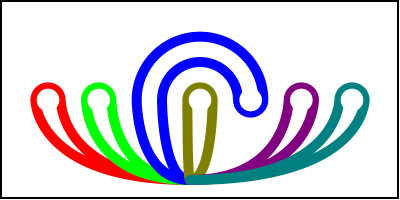

In [6]:
dessine_auto_de_tresse([3, 5, -5 ], hauteur = 200, largeur = 400, largeur_brin = 10, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a53m5.png')

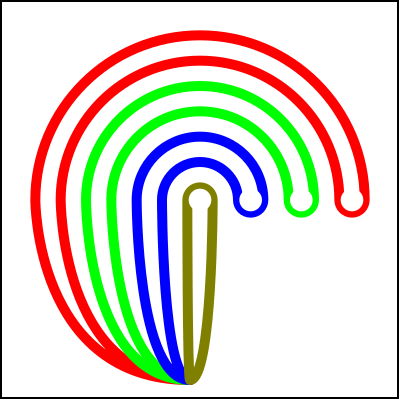

In [4]:
dessine_auto_de_tresse([1, 2, 3, 1, 2, 1], hauteur = 400, largeur = 400, largeur_brin = 10, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a123121.png')

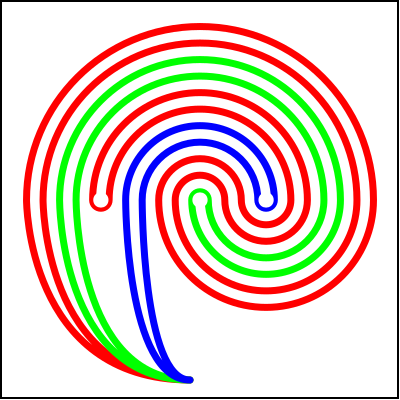

In [5]:
dessine_auto_de_tresse([1, 1, 2, 2], hauteur = 400, largeur = 400, largeur_brin = 7,
                           couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a1122.png')

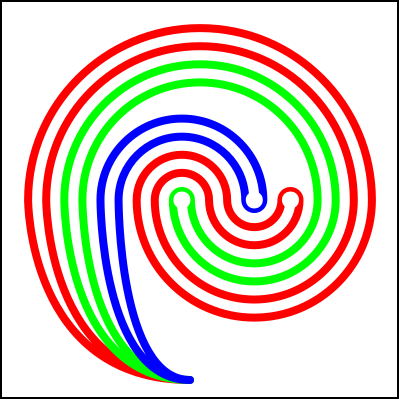

In [6]:
dessine_auto_de_tresse([1, 1, 2, 2, 1, 2], hauteur = 400, largeur = 400, largeur_brin = 8,
                           couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a112212.png')

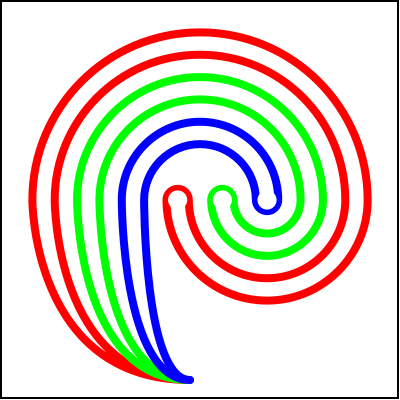

In [7]:
dessine_auto_de_tresse([1, 1, 2, 2, 1, 2, 2, -1], hauteur = 400, largeur = 400, largeur_brin = 8,
                           couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a1122122m1.png')

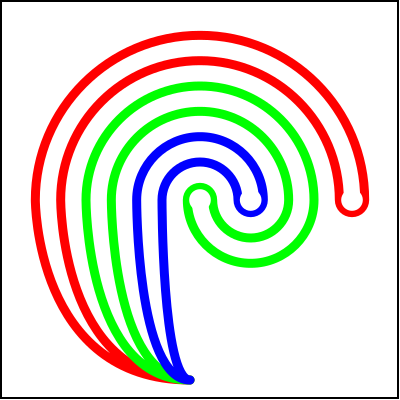

In [8]:
dessine_auto_de_tresse([1, 1, 2, 2, 1, 2, 2, -1, -1, -2], hauteur = 400, largeur = 400, largeur_brin = 9,
                           couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a1122122m1m1m2.png')

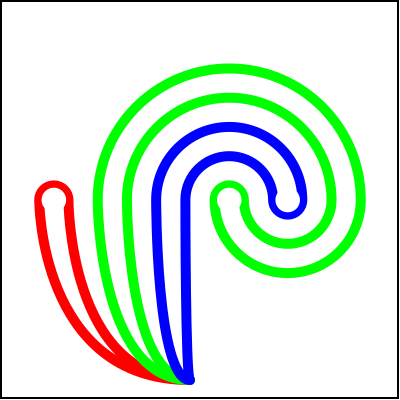

In [9]:
dessine_auto_de_tresse([1, 1, 2, 2, 1, 2, 2, -1, -1, -2, -2, -1], hauteur = 400, largeur = 400, largeur_brin = 10,
                           couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a1122122m1m1m2m2m1.png')

On tire finalement sur le jaune pour annuler totalement la tresse initiale. On obtient donc une forme _normale_ de la tresse initiale qui est l'inverse du mot rajouté en tirant sur les brins soit : $\sigma_2\sigma_2\sigma_1\sigma_2\sigma_2\sigma_1\sigma_1\sigma_{-2}\sigma_{-2}\sigma_{-1}$

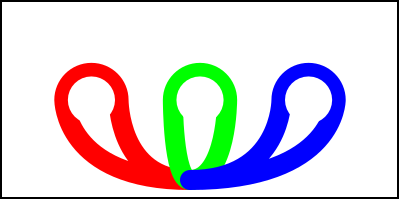

In [10]:
dessine_auto_de_tresse([1, 1, 2, 2, 1, 2, 2, -1, -1, -2, -2, -1, -2, -2], hauteur = 200, largeur = 400, 
                            largeur_brin = 20,
                           couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a1122122m1m1m2m2m1m2m2.png')

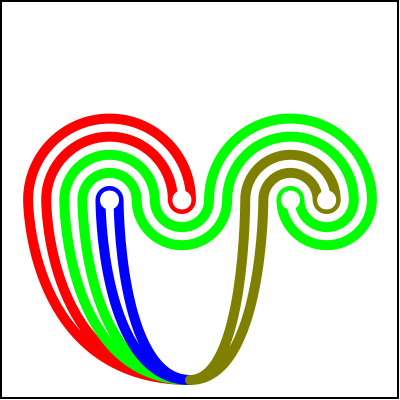

In [11]:
dessine_auto_de_tresse([2, 3, 1, 3], hauteur = 400, largeur = 400, largeur_brin = 10, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a2313.png')

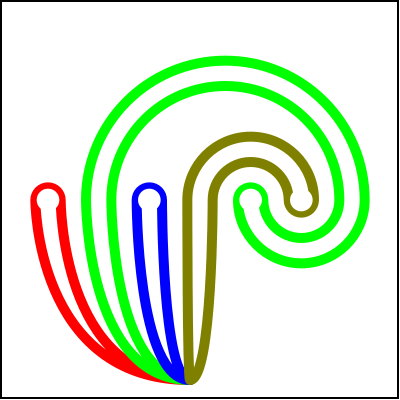

In [12]:
dessine_auto_de_tresse([2, 3, 1, 3, -1], hauteur = 400, largeur = 400, largeur_brin = 10, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a2313m1.png')

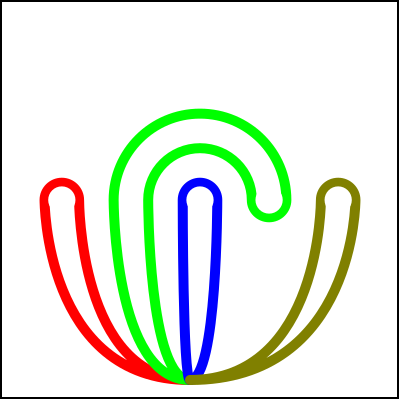

In [13]:
dessine_auto_de_tresse([2, 3, 1, 3, -1, -3, -3], hauteur = 400, largeur = 400, largeur_brin = 10, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a2313m1m3m3.png')

La tresse en forme _normale_ est donc $\sigma_2 \sigma_3 \sigma_3 \sigma_1$ 

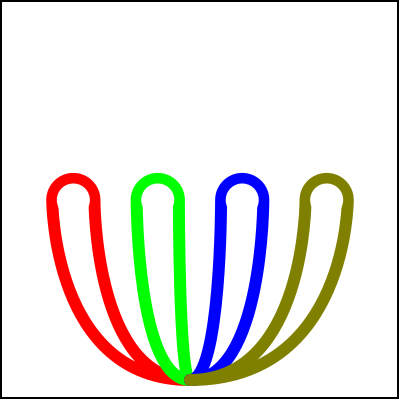

In [14]:
dessine_auto_de_tresse([2, 3, 1, 3, -1, -3, -3, -2], hauteur = 400, largeur = 400, largeur_brin = 12, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a2313m1m3m3m2.png')

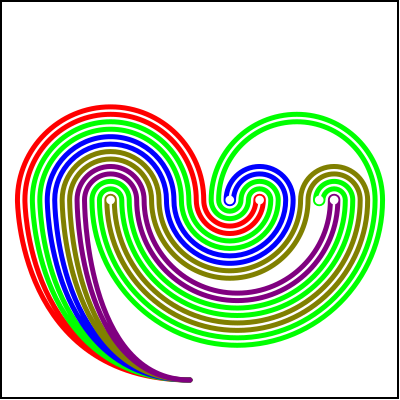

In [15]:
dessine_auto_de_tresse([2, 3, 3, -1, 4, 4, 3, 2,1], hauteur = 400, largeur = 400, largeur_brin = 5, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a233m144321.png')

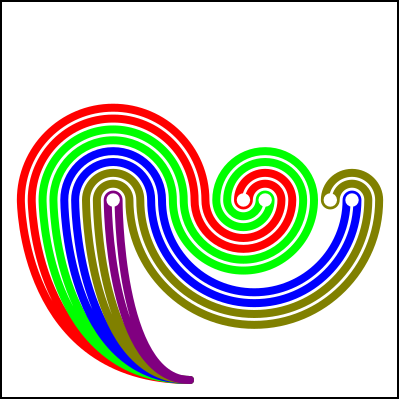

In [16]:
dessine_auto_de_tresse([4, 3, -1,-1, 2, -4, 1], hauteur = 400, largeur = 400, largeur_brin = 8, 
                            couleur_trous = (1,1,1), couleur_fond = (1,1,1), fichier = '../imgs/a43m1m12m41.png')